In [13]:
import sys, time, os, pywt, tqdm, datetime
import numpy as np
import pandas as pd
import uproot
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import struct
from numba import njit
#@njit(parallel=True)
pd.set_option('display.max_rows', None)
pd.options.display.width = 0
filename = "../wavedump-3.10.0/wave0.dat"



Event size   :  8224
File size    :  238347968
N of Events  :  28982.0


/home/u296464/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/28982.0 [00:00<?, ?it/s]

(6, 7)
   Event     decay   drift     energy       energy2       energy3        time
0    0.0  0.087405   536.0  1299.2600  1.358101e+03  1.363461e+03   5870779.0
1    1.0  0.087839   346.0  1021.2197  1.068038e+03  1.071498e+03   6521407.0
2    2.0  0.000098  2511.0     0.0000  2.664030e+07  2.664033e+07  13198667.0
3    3.0 -0.227230 -4075.0     0.0000 -3.628718e+05 -3.629125e+05  15111831.0
4    4.0  0.082963   434.0   575.1253  6.046080e+02  6.089480e+02  15148117.0


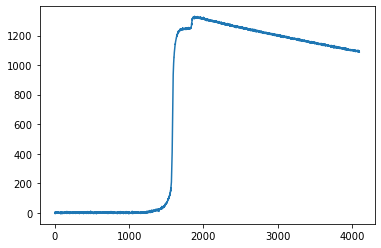

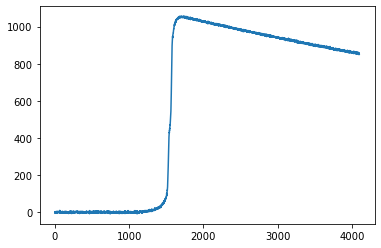

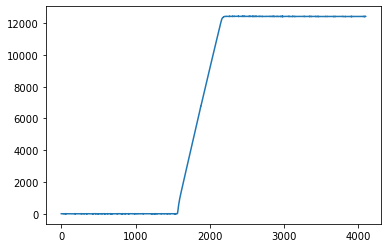

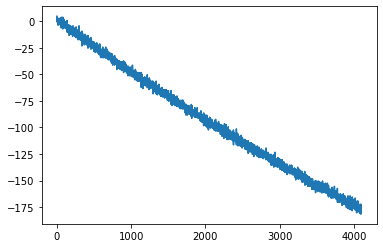

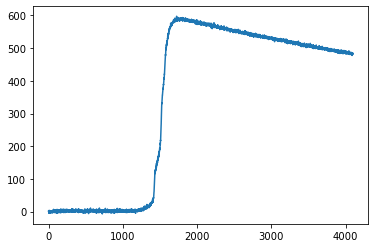

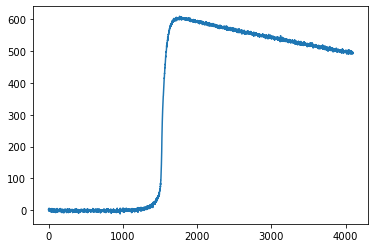

In [23]:
filename = "../wavedump-3.10.0/wave0.dat"
f=open(filename,"rb")
EVENT_SIZE = struct.unpack("i", f.read(4))[0]
FILE_SIZE = os.path.getsize(filename)
nOfEvents = FILE_SIZE / EVENT_SIZE
print("Event size   : ",EVENT_SIZE)
print("File size    : ",FILE_SIZE)
print("N of Events  : ",nOfEvents)


def decodeOneEvent(event):
    BoardID = struct.unpack("i", event[0:4])[0]
    #Pattern = struct.unpack("i", event[4:8])[0]
    Channel = struct.unpack("i", event[8:12])[0]
    Counter = struct.unpack("i", event[12:16])[0]
    Time    = struct.unpack("i", event[16:20])[0]
    wf = struct.unpack("H"*(len(event[20:])//2), event[20:])
    baseline = np.average(wf[0:50])
    wf = -1*(wf - baseline)
    baselinerms = np.std(wf[0:50])
    tzero = len(wf) - len(wf[wf>4*baselinerms])
    slope = np.sum(wf[-20:]) - np.sum(wf[0:20])
    slope2 = np.sum(wf[-220:-200]) - np.sum(wf[-20:])
    trap = np.zeros(len(wf))
    wf_pz = wf.copy()
    wf_time = np.arange(len(wf))
    #trap parameters
    t_rise = 500 #4ns ticks x 40
    t_flat = 500
    n = np.arange(t_rise,len(wf)- t_rise - t_flat)
    #pz correction
    dt = 400
    dt_offset = len(wf)-200-dt
    lam = np.log(np.sum(wf[dt_offset:dt_offset+200]) / np.sum(wf[dt_offset+dt:dt_offset+200+dt]) )/dt *1000
    if(slope>0) & (slope2>20):
        for i in range(len(trap)):
            if i in n:
                trap[i] = (np.sum(wf[i+t_flat:i+t_flat+t_rise]) - np.sum(wf[i-t_rise:i]))/t_rise
            wf_pz -= wf_pz[i] * np.where(wf_time<=i,0,np.exp(-0.00008738*(wf_time-i)))
    
    wf_pzInt = np.cumsum(wf_pz)
    tend = len(wf_pzInt[wf_pzInt<(np.average(wf_pzInt[-50:])-4*baselinerms)])
    
    energy = [np.mean(trap[tzero-20:tzero+20]),np.average(wf_pzInt[-200:]),np.average(wf_pzInt[-200:])+(tend-tzero)/100]
    return Channel, Counter, Time, wf, [slope,slope2], trap, energy, lam, np.cumsum(wf_pz),tzero, tend
    

f.seek(0)
pbar = tqdm.tqdm_notebook(total=nOfEvents)
dataframe = pd.DataFrame()

#f.seek(int(EVENT_SIZE*(nOfEvents-20)))
while True:
    EVENT_SIZE = struct.unpack("i", f.read(4))[0]
    OneEvent = f.read(EVENT_SIZE-4)    
    data = decodeOneEvent(OneEvent)
    pbar.update(1)
    #if (data[4][0]>0) & (data[4][1]>20):
    if True:
        new_row = {'Event':data[1], 'time':data[2], 'energy':data[6][0], 'energy2':data[6][1], 'energy3':data[6][2], 'decay':data[7], 'drift':data[10]-data[9]}
        dataframe = dataframe.append(new_row, ignore_index=True)
        
        plt.figure()
        #plt.title("{}, {} : {}".format(data[6][2],data[10]-data[9], data[4]))
        plt.plot(data[3])
        #plt.plot(data[5])
        #plt.plot(data[8])
        #plt.vlines(data[9],0,data[6][2])
        #plt.vlines(data[10],0,data[6][2])
        #plt.yscale('log')
        #plt.xlim([500, 1500])
        #plt.ylim([-100, 100])
        #   break
    if(f.tell() == FILE_SIZE):
        break
    if(f.tell() > 5*EVENT_SIZE):
        break

f.close

print(dataframe.shape)
print(dataframe.head())

In [3]:
dataframe.to_hdf("wave.h5",key='dataframe', mode='w')

(57, 7)
   Event     decay  drift  energy      energy2      energy3        time
0    0.0  0.087405  536.0     0.0  1358.100886  1363.460886   5870779.0
1    1.0  0.087839  346.0     0.0  1068.038381  1071.498381   6521407.0
2    4.0  0.082963  434.0     0.0   604.607976   608.947976  15148117.0
3    5.0  0.087050  338.0     0.0   616.526302   619.906302  15215897.0
4    6.0  0.085053  363.0     0.0  1022.207414  1025.837414  15890085.0
5    8.0  0.084346  422.0     0.0  1694.501763  1698.721763  17405909.0
6   10.0  0.086713  366.0     0.0  1307.486040  1311.146040  17475429.0
7   12.0  0.084608  420.0     0.0  1448.150367  1452.350367  19057005.0
8   14.0  0.086733  361.0     0.0  1435.852410  1439.462410  19419157.0
9   16.0  0.084732  474.0     0.0  1802.321068  1807.061068  23980131.0
0.073546086
0.08678703075933528


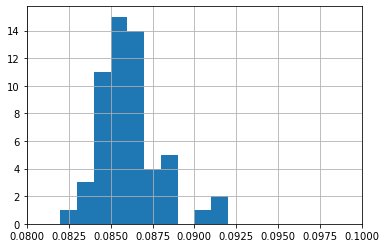

In [4]:
dataframe = pd.read_hdf("wave.h5", "dataframe")
print(dataframe.shape)
print(dataframe.head(10))
dataframe['time'] = (dataframe['time'] - np.min(dataframe['time']))/1E9
print(np.max(dataframe['time']))

dataframe['decay'].hist(bins=100,range=(0,0.1))
#plt.yscale('log')
plt.xlim([0.08, 0.1])
print(np.mean(dataframe['decay']))

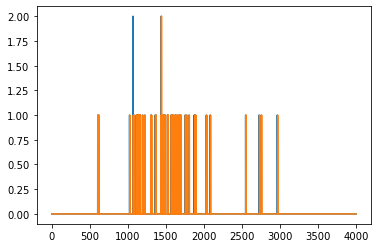

In [46]:
#h1=np.histogram(dataframe['energy'] *0.8392-21.3163,bins=4000, range=(0,4000))
#h2=np.histogram(dataframe['energy2'],bins=50, range=(0,5000))
#h3=np.histogram(dataframe['energy3']*0.7771+2.9292,bins=4000, range=(0,4000))

#h1=np.histogram(dataframe['energy'],bins=4000, range=(0,4000))
h2=np.histogram(dataframe['energy2'],bins=4000, range=(0,4000))
h3=np.histogram(dataframe['energy3'],bins=4000, range=(0,4000))

#plt.plot(h1[1][:-1],h1[0])
plt.plot(h2[1][:-1],h2[0])
plt.plot(h3[1][:-1],h3[0])
#plt.xlim([1400, 2000])
#plt.ylim([0, 10])
#plt.autoscale(enable=True, axis='y')
#plt.yscale('log')



(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([300., 304., 308., 312., 316., 320., 324., 328., 332., 336., 340.,
        344., 348., 352., 356., 360., 364., 368., 372., 376., 380., 384.,
        388., 392., 396., 400., 404., 408., 412., 416., 420., 424., 428.,
        432., 436., 440., 444., 448., 452., 456., 460., 464., 468., 472.,
        476., 480., 484., 488., 492., 496., 500.]),
 array([2000., 2030., 2060., 2090., 2120., 2150., 2180., 2210., 2240.,
        2270., 2300., 2330., 2360., 2390., 2420., 2450., 2480., 2510.,
        2540., 2570., 2600., 2630., 2660., 2690., 2720., 2750., 2780.,
        2810., 2840., 2870., 2900., 2930., 2960., 2990., 3020., 3050.,
        3080., 3110., 3140., 3170., 3200., 3230., 3260., 3290., 3320.,
        3350., 3380., 3410., 3440., 3470., 3500.

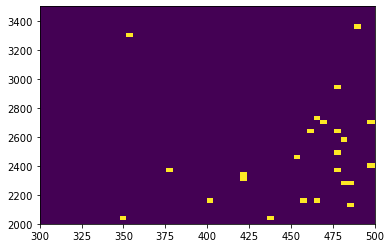

In [23]:
plt.figure()
plt.hist2d(dataframe['drift'],dataframe['energy2'], bins=[50,50], range=[[300, 500],[2000, 3500]])
